In [1]:
import warnings
warnings.filterwarnings('ignore')

# PowerPoint/PDF RAG 시스템 구축

이 노트북은 PDF 파일들을 읽어서 RAG(Retrieval-Augmented Generation) 시스템을 구축하는 과정을 보여줍니다.

주요 단계:
1. PDF 파일들을 마크다운으로 변환
2. LangChain Document 객체로 변환
3. 벡터 데이터베이스 구축 및 검색 시스템 설정


In [1]:
import pymupdf4llm
import os
from pathlib import Path

# PDF 파일들이 있는 폴더 경로
pdf_folder = "data/bcg_ppt"

# 폴더 내의 모든 PDF 파일 찾기
pdf_files = list(Path(pdf_folder).glob("*.pdf"))

# 각 PDF 파일을 마크다운으로 변환
md_texts = {}
for pdf_file in pdf_files:
    print(f"Processing: {pdf_file}")
    md_text = pymupdf4llm.to_markdown(str(pdf_file), page_chunks = True)
    md_texts[pdf_file.name] = md_text
    
print(f"총 {len(md_texts)}개의 PDF 파일을 처리했습니다.")


Processing: data\bcg_ppt\Corporate Ventures in Sweden.pdf
Processing data\bcg_ppt\Corporate Ventures in Sweden.pdf...
[                                        ] (0/2[=                                       ] ( 1/2[==                                      ] ( 2/28=[====                                    ] ( 3/28[=====                                   ] ( 4/2=[=======                                 ] ( 5/2[========                                ] ( 6/28=[==========                              ] ( 7/28[===========                             ] ( 8/2[============                            ] ( 9/28=[==============                          ] (10/28[===============                         ] (11/2=[=================                       ] (12/2[==================                      ] (13/28=[====================                    ] (14/28[=====================                   ] (15/2[======================                  ] (16/28=[========================                ] (17/28[=

In [5]:
print(md_texts["The Economic Impact of Ford and the F-Series.pdf"][6]['text'])

###### F-SERIES
 The F-Series supports ~500,000 American jobs, representing ~13–14 jobs for every direct Ford employee


###### 13–14x total multiple


###### Direct Community jobs

 Suppliers


###### Dealers


###### Community jobs

 Dealer suppliers


###### Total


###### E.g. F-Series assembly F-Series supplier Dealer sales Dealer's
 line staff member, machinist, staff, vehicle accountant, Ford engineer community nurse technician community teacher

Sources: Bureau of Labor Statistics (2019); F-Series supplier spending (2019); F-Series P&L (2019); F-Series plant-level costs
and headcounts (2019); RIMS II ratios (2012 and 2017); Ford government relations (2019); public dealer reports; BCG
analysis; image: Ford.
Note: Dealers attributable to F-Series sales are based on state-level F-Series sales volume. Jobs supported exclude any


-----




### Document 객체 생성

각 PDF 파일의 페이지별 마크다운 텍스트를 LangChain Document 객체로 변환합니다.

이를 통해 벡터 데이터베이스에서 사용할 수 있는 형태로 데이터를 준비합니다.


In [6]:
from langchain.schema import Document

# md_texts의 각 PDF 파일에 대해 Document 객체들을 생성
documents = []
for pdf_name, pages in md_texts.items():
    for page in pages:
        doc = Document(
            page_content=page['text'],
            metadata={
                'file_name': pdf_name,
                **page['metadata']
            }
        )
        documents.append(doc)

print(f"총 {len(documents)}개의 Document가 생성되었습니다.")

총 463개의 Document가 생성되었습니다.


In [7]:
documents[0].page_content

'# Corporate Ventures in Sweden\n## How to improve the connection between Swedish start-ups and corporations?\n\n##### April 2016\n\n\n-----\n\n'

In [32]:
%pip install pdf2image

### PDF를 이미지로 변환

각 PDF 파일의 페이지를 PNG 이미지로 변환하여 저장합니다.

PyMuPDF(fitz)를 사용하여 PDF의 각 페이지를 픽스맵으로 변환한 후 이미지 파일로 저장합니다.


In [8]:
from pathlib import Path
import fitz  # PyMuPDF

# 각 PDF 파일을 마크다운으로 변환 및 이미지 추출
md_texts = {}
for pdf_file in pdf_files:
    print(f"Processing: {pdf_file}")
    
    # PDF를 이미지로 변환하여 저장
    pdf_name = pdf_file.stem  # 확장자 제외한 파일명
    output_folder = Path(pdf_folder) / f"{pdf_name}_images"
    output_folder.mkdir(exist_ok=True)
    
    # PyMuPDF로 PDF 열기
    doc = fitz.open(str(pdf_file))
    
    # 각 페이지를 이미지로 변환
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        # 픽스맵으로 변환 (기본 해상도)
        pix = page.get_pixmap()
        image_path = output_folder / f"page_{page_num+1}.png"
        pix.save(str(image_path))
        print(f"  Saved: {image_path}")
    
    doc.close()


Processing: data\bcg_ppt\Corporate Ventures in Sweden.pdf
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_1.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_2.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_3.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_4.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_5.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_6.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_7.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_8.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_9.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_10.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_11.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_12.png
  Saved: data\bcg_ppt\Corporate Ventures in Sweden_images\page_13.png
  Saved: data\bcg_ppt\Corporate Ventures 

### 이미지 캡셔닝을 통한 텍스트 추출

앞서 생성한 PDF 페이지 이미지들을 Google Gemini 모델을 사용하여 분석하고, 각 페이지의 내용을 상세한 텍스트로 변환합니다.

- `create_page_caption_message()`: PDF 페이지 이미지와 기존 추출된 텍스트를 함께 분석하여 정확한 캡션 생성
- `process_pdf_images_with_captions()`: 모든 PDF 이미지에 대해 캡셔닝을 수행하고 결과를 저장
- Gemini 2.5 Flash 모델을 사용하여 이미지 내용을 구조화된 텍스트로 변환



In [6]:
from pathlib import Path
import base64
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import time

load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20")

def create_page_caption_message(image_path: Path, page_text: str) -> HumanMessage:
    """페이지 텍스트를 컨텍스트로 활용한 캡션 생성 메시지"""
    try:
        with open(image_path, "rb") as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
        
        prompt = f"""다음은 BCG 컨설팅 리포트의 한 페이지입니다. 
        이미지를 분석하여 페이지의 내용을 정확하고 상세하게 텍스트로 변환해주세요.

참고용 추출 텍스트 (순서나 구조가 부정확할 수 있음):
{page_text[:1000]}{'...' if len(page_text) > 1000 else ''}

위 텍스트는 참고용이며, 실제 이미지의 내용과 구조가 다를 수 있습니다. 
이미지를 직접 분석하여 다음과 같이 작성해주세요:

1. 페이지의 제목이나 헤더
2. 주요 텍스트 내용 (단락별로 구조화)
3. 차트, 그래프, 표가 있다면 그 내용과 데이터
4. 이미지나 다이어그램이 있다면 설명
5. 페이지 하단의 각주나 출처 정보

모든 텍스트를 읽기 쉽고 구조적으로 정리하여 한글로 작성해주세요."""

        return HumanMessage(
            content=[
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": f"data:image/png;base64,{encoded_image}"},
            ]
        )
    except Exception as e:
        print(f"메시지 생성 오류: {e}")
        return None

def process_pdf_images_with_captions():
    """각 PDF의 페이지 이미지에 대해 캡셔닝 수행"""
    all_captions = {}
    
    for pdf_file in pdf_files:
        pdf_name = pdf_file.stem
        image_folder = Path(pdf_folder) / f"{pdf_name}_images"
        
        if not image_folder.exists():
            print(f"이미지 폴더가 없습니다: {image_folder}")
            continue
            
        print(f"\n{pdf_name} 처리 중...")
        
        # 해당 PDF의 documents 찾기
        pdf_documents = [doc for doc in documents if doc.metadata['file_name'] == str(pdf_file)]
        
        # 페이지별 이미지 파일 찾기
        image_files = sorted(image_folder.glob("page_*.png"))
        
        batch_data = []
        for i, image_file in enumerate(image_files):
            page_num = i  # 0부터 시작하는 페이지 번호
            
            # 해당 페이지의 텍스트 찾기
            page_text = ""
            if page_num < len(pdf_documents):
                page_text = pdf_documents[page_num].page_content
            
            batch_data.append((image_file, page_text, f"{pdf_name}_page_{page_num+1}"))
        
        # 배치 처리 (16개씩 - 1000 RPM의 약 4분의 1 사용)
        batch_size = 16
        for batch_idx in range(0, len(batch_data), batch_size):
            batch = batch_data[batch_idx:batch_idx + batch_size]
            batch_num = batch_idx // batch_size + 1
            total_batches = (len(batch_data) + batch_size - 1) // batch_size
            
            print(f"  배치 {batch_num}/{total_batches} 처리 중... ({len(batch)}개 이미지)")
            
            # 배치용 메시지 준비
            batch_messages = []
            batch_keys = []
            
            for image_file, page_text, page_key in batch:
                message = create_page_caption_message(image_file, page_text)
                if message:
                    batch_messages.append([message])
                    batch_keys.append(page_key)
            
            # LCEL batch 실행
            if batch_messages:
                try:
                    batch_results = llm.batch(batch_messages)
                    
                    for i, result in enumerate(batch_results):
                        if i < len(batch_keys):
                            caption = result.content.strip()
                            all_captions[batch_keys[i]] = caption
                            print(f"    {batch_keys[i]}: {caption[:50]}...")
                            
                except Exception as e:
                    print(f"  배치 처리 오류: {e}")
                    # 개별 처리로 폴백
                    for i, message_list in enumerate(batch_messages):
                        try:
                            result = llm.invoke(message_list)
                            caption = result.content.strip()
                            all_captions[batch_keys[i]] = caption
                            print(f"    {batch_keys[i]}: {caption[:50]}...")
                            time.sleep(0.1)  # 개별 요청 간 짧은 대기
                        except Exception as individual_error:
                            print(f"    {batch_keys[i]}: 캡션 생성 실패")
                            all_captions[batch_keys[i]] = "[캡션 생성 실패]"
            
            # Rate limit 대기 (마지막 배치가 아닌 경우)
            # 1000 RPM = 16.67 requests/sec이므로 16개 요청 후 약 1초 대기
            if batch_num < total_batches:
                wait_time = 1.0
                print(f"  Rate limit 대기 중... ({wait_time}초)")
                time.sleep(wait_time)
    
    return all_captions

# 캡셔닝 실행
print("PDF 페이지 이미지 캡셔닝을 시작합니다...")
start_time = time.time()

captions = process_pdf_images_with_captions()

end_time = time.time() - start_time
print(f"\n캡셔닝 완료! 총 소요 시간: {end_time:.2f}초")
print(f"총 {len(captions)}개 페이지 캡션 생성됨")

# 결과 확인
for key, caption in list(captions.items())[:3]:
    print(f"\n{key}: {caption}")

PDF 페이지 이미지 캡셔닝을 시작합니다...

Corporate Ventures in Sweden 처리 중...
  배치 1/2 처리 중... (16개 이미지)
    Corporate Ventures in Sweden_page_1: BCG 컨설팅 리포트의 해당 페이지를 분석한 결과는 다음과 같습니다. 이 페이지는 보고서의...
    Corporate Ventures in Sweden_page_2: BCG 컨설팅 리포트 페이지의 내용을 다음과 같이 분석하여 텍스트로 변환했습니다.

---...
    Corporate Ventures in Sweden_page_3: BCG 컨설팅 리포트 페이지를 분석한 내용은 다음과 같습니다.

---

**1. 페이지의...
    Corporate Ventures in Sweden_page_4: 다음은 BCG 컨설팅 리포트 페이지의 내용 분석입니다.

---

**1. 페이지의 제목이...
    Corporate Ventures in Sweden_page_5: 다음은 BCG 컨설팅 리포트 페이지의 분석 결과입니다.

---

**페이지 번호:** 3...
    Corporate Ventures in Sweden_page_6: 다음은 BCG 컨설팅 리포트 페이지의 내용을 분석하여 텍스트로 변환한 것입니다.

---
...
    Corporate Ventures in Sweden_page_7: 다음은 BCG 컨설팅 리포트 페이지의 분석 결과입니다.

---

**BCG 컨설팅 리포트...
    Corporate Ventures in Sweden_page_8: 제공된 이미지를 분석한 결과는 다음과 같습니다.

---

**BCG 컨설팅 리포트 페이지...
    Corporate Ventures in Sweden_page_9: BCG 컨설팅 리포트 페이지를 분석한 결과는 다음과 같습니다.

---

**1. 페이지의...
    Corporate Ventures in Sweden_page_10: BCG 컨설팅 리포트 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


    Loose dogs in Dallas_page_81: BCG 컨설팅 리포트 페이지를 분석한 결과는 다음과 같습니다.

---

**1. 페이지의...
    Loose dogs in Dallas_page_82: 다음은 BCG 컨설팅 리포트의 한 페이지를 분석하여 텍스트로 변환한 내용입니다.

---
...
    Loose dogs in Dallas_page_83: 다음은 BCG 컨설팅 리포트 페이지의 분석 결과입니다.

---

**1. 페이지의 제목 ...
    Loose dogs in Dallas_page_84: 다음은 BCG 컨설팅 리포트 페이지의 분석 결과입니다.

---

**1. 페이지의 제목이...
    Loose dogs in Dallas_page_85: BCG 컨설팅 리포트 페이지를 분석한 결과입니다.

---

**1. 페이지 제목 및 헤더...
    Loose dogs in Dallas_page_86: BCG 컨설팅 리포트 페이지의 내용을 정확하고 상세하게 텍스트로 변환했습니다.

---

...
    Loose dogs in Dallas_page_87: BCG 컨설팅 리포트 페이지 분석 결과는 다음과 같습니다.

---

**BCG 컨설팅 리...
    Loose dogs in Dallas_page_88: BCG 컨설팅 리포트 페이지의 내용을 분석하여 텍스트로 변환한 결과입니다.

---

**...
    Loose dogs in Dallas_page_89: 다음은 BCG 컨설팅 리포트 페이지의 분석 결과입니다.

---

### 1. 페이지의 제...
    Loose dogs in Dallas_page_90: BCG 컨설팅 리포트 페이지의 내용을 분석하여 다음과 같이 텍스트로 변환했습니다.

---...
    Loose dogs in Dallas_page_91: BCG 컨설팅 리포트 페이지의 내용을 분석하여 다음과 같이 텍스트로 변환했습니다.

---...
    Loose dogs in Dallas_page_92

In [9]:
captions['Corporate Ventures in Sweden_page_1']

NameError: name 'captions' is not defined

In [18]:
for doc in documents[:10]:
    # 문서 메타데이터에서 페이지 번호 추출
    page_num = doc.metadata.get('page')
    source = doc.metadata.get('file_name', '')
    
    # 캡션 키 생성 (process_pdf_images_with_captions에서 사용한 것과 동일)
    # 소스 파일명에서 확장자 제거 후 page 번호 추가
    source_basename = source.split('/')[-1].replace('.pdf', '')
    caption_key = f"{source_basename}_page_{page_num}"
    print(caption_key)

Corporate Ventures in Sweden_page_1
Corporate Ventures in Sweden_page_2
Corporate Ventures in Sweden_page_3
Corporate Ventures in Sweden_page_4
Corporate Ventures in Sweden_page_5
Corporate Ventures in Sweden_page_6
Corporate Ventures in Sweden_page_7
Corporate Ventures in Sweden_page_8
Corporate Ventures in Sweden_page_9
Corporate Ventures in Sweden_page_10


### 문서 페이지 내용을 캡션으로 업데이트

PDF 페이지에서 추출된 텍스트 대신 캡션을 사용하여 문서 객체들을 업데이트합니다.

In [19]:
# Document 객체들의 page_content를 캡션으로 업데이트
print("Document 객체들의 page_content를 캡션으로 업데이트 중...")

updated_documents = []
for doc in documents:
    # 문서 메타데이터에서 페이지 번호 추출
    page_num = doc.metadata.get('page')
    source = doc.metadata.get('file_name', '')
    
    # 캡션 키 생성 (process_pdf_images_with_captions에서 사용한 것과 동일)
    # 소스 파일명에서 확장자 제거 후 page 번호 추가
    source_basename = source.split('/')[-1].replace('.pdf', '')
    caption_key = f"{source_basename}_page_{page_num}"
    
    # 해당 페이지의 캡션 가져오기
    if caption_key in captions:
        # 새로운 Document 생성 (page_content를 캡션으로 대체)
        updated_doc = Document(
            page_content=captions[caption_key],
            metadata=doc.metadata.copy()  # 기존 메타데이터 유지
        )
        updated_documents.append(updated_doc)
        print(f"  페이지 {page_num}: 캡션으로 업데이트 완료")

print(f"\n총 {len(updated_documents)}개 문서 업데이트 완료")

# 업데이트된 문서들의 샘플 확인
print("\n업데이트된 문서 샘플:")
for i, doc in enumerate(updated_documents[:3]):
    print(f"\n문서 {i+1}:")
    print(f"  메타데이터: {doc.metadata}")
    print(f"  내용 (처음 100자): {doc.page_content[:100]}...")

# 기존 documents를 updated_documents로 교체
documents = updated_documents


Document 객체들의 page_content를 캡션으로 업데이트 중...
  페이지 1: 캡션으로 업데이트 완료
  페이지 2: 캡션으로 업데이트 완료
  페이지 3: 캡션으로 업데이트 완료
  페이지 4: 캡션으로 업데이트 완료
  페이지 5: 캡션으로 업데이트 완료
  페이지 6: 캡션으로 업데이트 완료
  페이지 7: 캡션으로 업데이트 완료
  페이지 8: 캡션으로 업데이트 완료
  페이지 9: 캡션으로 업데이트 완료
  페이지 10: 캡션으로 업데이트 완료
  페이지 11: 캡션으로 업데이트 완료
  페이지 12: 캡션으로 업데이트 완료
  페이지 13: 캡션으로 업데이트 완료
  페이지 14: 캡션으로 업데이트 완료
  페이지 15: 캡션으로 업데이트 완료
  페이지 16: 캡션으로 업데이트 완료
  페이지 17: 캡션으로 업데이트 완료
  페이지 18: 캡션으로 업데이트 완료
  페이지 19: 캡션으로 업데이트 완료
  페이지 20: 캡션으로 업데이트 완료
  페이지 21: 캡션으로 업데이트 완료
  페이지 22: 캡션으로 업데이트 완료
  페이지 23: 캡션으로 업데이트 완료
  페이지 24: 캡션으로 업데이트 완료
  페이지 25: 캡션으로 업데이트 완료
  페이지 26: 캡션으로 업데이트 완료
  페이지 27: 캡션으로 업데이트 완료
  페이지 28: 캡션으로 업데이트 완료
  페이지 1: 캡션으로 업데이트 완료
  페이지 2: 캡션으로 업데이트 완료
  페이지 3: 캡션으로 업데이트 완료
  페이지 4: 캡션으로 업데이트 완료
  페이지 5: 캡션으로 업데이트 완료
  페이지 6: 캡션으로 업데이트 완료
  페이지 7: 캡션으로 업데이트 완료
  페이지 8: 캡션으로 업데이트 완료
  페이지 9: 캡션으로 업데이트 완료
  페이지 10: 캡션으로 업데이트 완료
  페이지 11: 캡션으로 업데이트 완료
  페이지 12: 캡션으로 업데이트 완료
  페이지 13: 캡션으로 업데이트 완료
  페이지 14: 캡션으로 업데이트 완료
  페이지 15:

### 벡터 스토어 설정 및 문서 저장

Qdrant를 사용하여 하이브리드 검색(Dense + Sparse) 벡터 스토어를 설정하고, 업데이트된 문서들을 저장합니다.


In [1]:
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, SparseVectorParams, VectorParams

# Qdrant 클라이언트 설정
client = QdrantClient(host="localhost", port=6333)

dense_embeddings = OllamaEmbeddings(model="bge-m3")
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

# 컬렉션 이름 설정
collection_name = f"ppt_rag"
try:
    client.create_collection(
        collection_name=collection_name,
        vectors_config={"dense": VectorParams(size=1024, distance=Distance.COSINE)},
        sparse_vectors_config={
            "sparse": SparseVectorParams(index=models.SparseIndexParams(on_disk=False))
        },
    )
    print(f"새 컬렉션 '{collection_name}' 생성됨")
    qdrant = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=dense_embeddings,
        sparse_embedding=sparse_embeddings,
        retrieval_mode=RetrievalMode.HYBRID,
        vector_name="dense",
        sparse_vector_name="sparse",
    )

    # 문서를 벡터 스토어에 추가
    print("문서를 벡터 스토어에 추가 중...")
    qdrant.add_documents(documents)
    print(f"✅ {len(documents)}개의 문서가 Qdrant에 저장되었습니다.")
    
except:
    qdrant = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=dense_embeddings,
        sparse_embedding=sparse_embeddings,
        retrieval_mode=RetrievalMode.HYBRID,
        vector_name="dense",
        sparse_vector_name="sparse",
    )

In [12]:
qdrant.similarity_search("동물 복지의 현황", k=5)

[Document(metadata={'file_name': 'Loose dogs in Dallas.pdf', 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe Acrobat Pro 11.0.17', 'producer': 'Adobe Acrobat Pro 11.0.17', 'creationDate': "D:20160829115629-05'00'", 'modDate': "D:20160829115645-05'00'", 'trapped': '', 'encryption': None, 'file_path': 'data\\bcg_ppt\\Loose dogs in Dallas.pdf', 'page_count': 406, 'page': 404, '_id': '74dcafff-d282-4b9d-8fe2-40351bc0aa15', '_collection_name': 'ppt_rag'}, page_content='BCG 컨설팅 리포트 페이지의 내용을 분석하여 다음과 같이 텍스트로 변환했습니다.\n\n---\n\n**1. 페이지의 제목이나 헤더**\n*   **BCG Strategic Recommendations to Improve Public Safety and Animal Welfare in Dallas | 2016**\n    (댈러스의 공공 안전 및 동물 복지 개선을 위한 BCG 전략적 권고사항 | 2016)\n\n**2. 주요 텍스트 내용**\n\n*   **권고사항 1 – 공공 안전과 동물 복지의 균형을 맞춘 사명 선언문을 공개적으로 채택**\n\n*   오늘날 DAS(Dallas Animal Services)의 사명은 웹사이트에 명시된 바와 같이 주로 동물 복지에 중점을 두고 있습니다.\n    *   댈러스 동물 서비스 및 입양 센터는 댈러스 내 동물의 인도적 대우와 책임감 있는 반려동물 소유권에 대한 교육에 헌신하고 있습니다. 우리는 매일 보호소

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### Multi-Query RAG 시스템

이 섹션에서는 단일 질문을 여러 관점의 질문으로 확장하여 더 포괄적인 검색을 수행하는 Multi-Query RAG 시스템을 구현합니다.

원본 질문을 다양한 관점에서 재구성하여 5개의 질문 생성합니다.


In [3]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_ollama import ChatOllama
from langchain.retrievers.multi_query import LineListOutputParser


generation_model = ChatOllama(model="gemma3:4b", temperature=0.1)

def create_multiquery_generator(llm, num_queries=3):
    """멀티쿼리 생성기 생성"""
    
    # Output parser 초기화
    output_parser = LineListOutputParser()
    
    # 멀티쿼리 생성 프롬프트
    QUERY_PROMPT =  PromptTemplate(
        input_variables=["question", "num_queries"],
        template="""당신은 AI 어시스턴트입니다. 사용자의 질문을 다양한 관점에서 재구성하여 
                    더 포괄적인 검색이 가능하도록 도와주세요. 거리 기반 유사도 검색의 한계를 극복하기 위해 
                    원본 질문에 대한 다양한 관점의 질문들을 {num_queries}개 생성해주세요.

                    각 질문은 줄바꿈으로 구분하여 제공해주세요.
                    원본 질문: {question}
                    {num_queries}개의 질문:
                    (print from here)
                    """
    )
    
    # 멀티쿼리 생성 체인 생성 (이것이 Runnable입니다)
    multiquery_chain = QUERY_PROMPT | llm | output_parser
    
    print(f"🔍 멀티쿼리 생성기 설정 완료 (질문 수: {num_queries}개)")
    return multiquery_chain

# 멀티쿼리 생성기 생성
multiquery_generator = create_multiquery_generator(generation_model, 5)
# multiquery_generator.invoke({"question": "애견 생태계", "num_queries": 5})

🔍 멀티쿼리 생성기 설정 완료 (질문 수: 5개)


### Agentic RAG 시스템

이 섹션에서는 LangGraph를 활용한 **Agentic RAG 시스템**을 구현합니다. 이는 기존의 단순한 RAG와는 다른 고급 접근 방식입니다.

#### 🔄 Agentic RAG의 핵심 원리

**기존 RAG의 한계:**
- 질문 → 검색 → 답변 생성의 단순한 선형 구조
- 복잡한 질문에 대해 충분하지 않은 정보 수집
- 답변의 품질을 검증하거나 개선하는 피드백 루프 부재

**Agentic RAG의 혁신:**
1. **🧠 지능적 라우팅**: 질문의 복잡도를 분석하여 적절한 처리 경로 선택
2. **📋 연구 계획 수립**: 복잡한 질문을 체계적인 단계로 분해
3. **🔍 반복적 검색**: 필요에 따라 여러 번의 검색과 분석 수행
4. **✅ 품질 검증**: 할루시네이션 체크와 답변 품질 검증
5. **🔄 피드백 루프**: 불충분한 답변 시 추가 정보 수집

In [4]:
from dataclasses import dataclass, field
from typing import Annotated, Literal, TypedDict, List, Dict, Any
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
import operator
import json
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

generation_model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
reasoning_model = ChatOpenAI(model="o4-mini", reasoning_effort="medium")

generation_local=ChatOllama(model="gemma3:4b", temperature=0)
reasoning_local=ChatOllama(model="qwen3", temperature=0)

gpt_model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# 1. 개선된 상태 정의
@dataclass(kw_only=True)
class InputState:
    """사용자 입력 상태"""
    messages: Annotated[List[AnyMessage], add_messages]

@dataclass(kw_only=True) 
class RAGState(InputState):
    """메인 RAG 워크플로우 상태"""
    # 라우팅 관련
    query_type: str = ""  # "simple", "complex", "needs_info"
    routing_logic: str = ""  # 라우팅 이유
    
    # Research Plan 관련
    research_steps: List[str] = field(default_factory=list)
    current_step: int = 0
    
    # 문서 및 답변
    documents: List[Document] = field(default_factory=list)
    final_answer: str = ""
    iterations: int = 0
    
    # 할루시네이션 체크
    is_factual: bool = True

# 2. Pydantic 라우터 모델 정의
class QueryRouter(BaseModel):
    """질문 라우팅을 위한 Pydantic 모델"""
    type: Literal["simple", "complex", "needs_info"] = Field(
        description="질문 유형: simple(단순 질문), complex(복잡한 분석), needs_info(정보 부족)"
    )
    logic: str = Field(
        description="해당 유형으로 분류한 이유와 설명"
    )

# 3. 개선된 질문 분석 및 라우팅
async def analyze_and_route_query(state: RAGState) -> Dict[str, Any]:
    """질문을 분석하고 적절한 경로로 라우팅"""
    
    router_prompt = """사용자의 질문을 분석하여 다음 중 하나로 분류해주세요:

1. "simple": 
   - 단순한 사실 확인 질문
   - 한 번의 검색으로 답변 가능
   - 예: "포드의 F-Series 매출은 얼마인가?", "스웨덴에서 가장 큰 기업벤처는?"

2. "complex":
   - 비교, 분석, 종합이 필요한 질문  
   - 여러 단계의 연구가 필요
   - 예: "포드와 GM의 전기차 전략 비교", "스웨덴 기업벤처의 성공 요인 분석"

3. "needs_info":
   - 질문이 모호하거나 더 구체적인 정보가 필요
   - 예: "이것에 대해 알려줘", "더 자세히 설명해줘"

질문: {question}
"""
    
    # Structured output을 사용한 안전한 파싱
    structured_llm = generation_model.with_structured_output(QueryRouter)
    prompt = router_prompt.format(question=state.messages[-1].content)
    
    try:
        router_result = structured_llm.invoke(prompt)
        return {
            "query_type": router_result.type,
            "routing_logic": router_result.logic
        }
    except Exception as e:
        print(f"라우팅 실패: {e}, 기본값으로 설정")
        return {
            "query_type": "simple", 
            "routing_logic": f"구조화된 출력 파싱 실패로 기본값 설정: {str(e)}"
        }

# 4. 라우팅 결정 함수
def route_by_query_type(state: RAGState) -> str:
    query_type = state.query_type
    print(f"질문 유형: {query_type} - {state.routing_logic}")
    
    if query_type == "simple":
        return "handle_simple_query" 
    elif query_type == "complex":
        return "create_research_plan"
    elif query_type == "needs_info":
        return "ask_for_more_info"
    else:
        return "handle_simple_query"

# 5. 간단한 질문 처리 (기존 multi-query 방식 유지)
async def handle_simple_query(state: RAGState) -> Dict[str, Any]:
    """간단한 질문을 multi-query retriever로 처리"""
    print("간단한 질문 처리 중...")
    
    question = state.messages[-1].content
    
    # Multi-query 생성
    multi_queries = multiquery_generator.invoke({"question": question, "num_queries": 5})
    
    all_docs = []
    for query in multi_queries:
        docs = qdrant.similarity_search(query, k=3)
        all_docs.extend(docs)

    # 중복 제거 및 상위 문서 선택
    unique_docs = list({doc.page_content: doc for doc in all_docs}.values())[:5]
    
    # 답변 생성
    context = "\n\n".join([doc.page_content for doc in unique_docs])
    answer_prompt = f"""
    다음 문서들을 참고하여 질문에 정확하게 답해주세요:
    
    질문: {question}
    
    참고 문서:
    {context}
    
    답변:
    """
    
    response = generation_model.invoke(answer_prompt)
    
    return {
        "documents": unique_docs,
        "final_answer": response.content,
        "messages": [AIMessage(content=response.content)]
    }

# 6. 연구 계획 생성을 위한 Pydantic 모델
class ResearchPlan(BaseModel):
    """연구 계획을 위한 Pydantic 모델"""
    steps: List[str] = Field(
        description="구체적이고 실행 가능한 연구 단계들의 리스트 (3-5개)"
    )

# 6. 연구 계획 생성
async def create_research_plan(state: RAGState) -> Dict[str, Any]:
    """복잡한 질문에 대한 단계별 연구 계획 생성"""
    print("연구 계획 생성 중...")
    
    plan_prompt = f"""다음 복잡한 질문에 답하기 위한 단계별 연구 계획을 세워주세요.
각 단계는 구체적이고 실행 가능해야 합니다.

질문: {state.messages[-1].content}

3-5개의 연구 단계를 제시해주세요.
"""
    
    # Structured output을 사용한 안전한 파싱
    structured_llm = reasoning_model.with_structured_output(ResearchPlan)
    
    try:
        plan_result = structured_llm.invoke(plan_prompt)
        steps = plan_result.steps
        print(f"생성된 연구 계획: {steps}")
        
        return {
            "research_steps": steps,
            "current_step": 0,
            "documents": []  # 문서 초기화
        }
    except Exception as e:
        print(f"연구 계획 생성 실패: {e}, 기본 계획 사용")
        # 기본 계획
        default_steps = [f"{state.messages[-1].content}에 대한 기본 조사"]
        return {
            "research_steps": default_steps,
            "current_step": 0,
            "documents": []
        }

# 7. 단계별 연구 수행
async def conduct_research_step(state: RAGState) -> Dict[str, Any]:
    """현재 연구 단계 실행"""
    current_step = state.current_step
    steps = state.research_steps
    
    if current_step >= len(steps):
        return {"current_step": current_step}
    
    step_query = steps[current_step]
    print(f"연구 단계 {current_step + 1}/{len(steps)} 실행: {step_query}")
    
    # 현재 단계에 대한 multi-query 생성 및 검색
    multi_queries = multiquery_generator.invoke({"question": step_query, "num_queries": 3})
    
    step_docs = []
    for query in multi_queries:
        docs = qdrant.similarity_search(query, k=3)
        step_docs.extend(docs)
    
    # 기존 문서와 병합
    all_docs = state.documents + step_docs
    unique_docs = list({doc.page_content: doc for doc in all_docs}.values())
    
    return {
        "documents": unique_docs,
        "current_step": current_step + 1
    }

# 8. 연구 완료 확인
def check_research_finished(state: RAGState) -> str:
    """연구가 완료되었는지 확인"""
    if state.current_step >= len(state.research_steps):
        print("모든 연구 단계 완료 -> 최종 답변 생성")
        return "generate_final_response"
    else:
        print(f"다음 연구 단계 진행 ({state.current_step + 1}/{len(state.research_steps)})")
        return "conduct_research_step"

# 9. 최종 답변 생성
async def generate_final_response(state: RAGState) -> Dict[str, Any]:
    """수집된 모든 정보를 바탕으로 최종 답변 생성"""
    print("최종 답변 생성 중...")
    
    question = state.messages[-1].content
    context = "\n\n".join([doc.page_content for doc in state.documents[:10]])  # 상위 10개 문서
    
    final_prompt = f"""
    다음은 단계별 연구를 통해 수집된 정보입니다. 이를 바탕으로 사용자의 질문에 종합적이고 상세한 답변을 제공해주세요.

    질문: {question}
    
    연구 단계들: {', '.join(state.research_steps)}
    
    수집된 정보:
    {context}
    
    위 정보들을 종합하여 질문에 대한 완전하고 구조화된 답변을 작성해주세요.
    답변은 다음 구조를 따르세요:
    1. 요약
    2. 주요 내용 (세부 분석)
    3. 결론
    
    답변:
    """
    
    response = gpt_model.invoke(final_prompt)
    
    return {
        "final_answer": response.content,
        "messages": [AIMessage(content=response.content)]
    }

# 10. 정보 부족 시 추가 정보 요청
async def ask_for_more_info(state: RAGState) -> Dict[str, Any]:
    """더 구체적인 정보를 요청"""
    
    clarification_prompt = f"""
    사용자의 질문이 모호합니다. 더 정확한 답변을 위해 구체적인 정보를 요청해주세요.
    
    사용자 질문: {state.messages[-1].content}
    모호한 이유: {state.routing_logic}
    
    친근하고 도움이 되는 방식으로 추가 정보를 요청하세요.
    """
    
    response = generation_model.invoke(clarification_prompt)
    
    return {
        "final_answer": response.content,
        "messages": [AIMessage(content=response.content)]
    }

# 11. 워크플로우 구성
def create_improved_rag_workflow():
    """개선된 RAG 워크플로우 생성"""
    
    workflow = StateGraph(RAGState, input=InputState)
    
    # 노드 추가
    workflow.add_node("analyze_and_route", analyze_and_route_query)
    workflow.add_node("handle_simple_query", handle_simple_query)
    workflow.add_node("create_research_plan", create_research_plan)
    workflow.add_node("conduct_research_step", conduct_research_step)
    workflow.add_node("generate_final_response", generate_final_response)
    workflow.add_node("ask_for_more_info", ask_for_more_info)
    
    # 엣지 설정
    workflow.set_entry_point("analyze_and_route")
    
    # 라우팅
    workflow.add_conditional_edges(
        "analyze_and_route",
        route_by_query_type,
        {
            "handle_simple_query": "handle_simple_query",
            "create_research_plan": "create_research_plan", 
            "ask_for_more_info": "ask_for_more_info"
        }
    )
    
    # 간단한 질문과 정보 요청은 바로 종료
    workflow.add_edge("handle_simple_query", END)
    workflow.add_edge("ask_for_more_info", END)
    
    # 복잡한 질문의 연구 플로우
    workflow.add_edge("create_research_plan", "conduct_research_step")
    workflow.add_conditional_edges(
        "conduct_research_step",
        check_research_finished,
        {
            "conduct_research_step": "conduct_research_step",
            "generate_final_response": "generate_final_response"
        }
    )
    workflow.add_edge("generate_final_response", END)
    
    # 메모리 설정
    memory = MemorySaver()
    return workflow.compile(checkpointer=memory)

# 사용법
app = create_improved_rag_workflow()


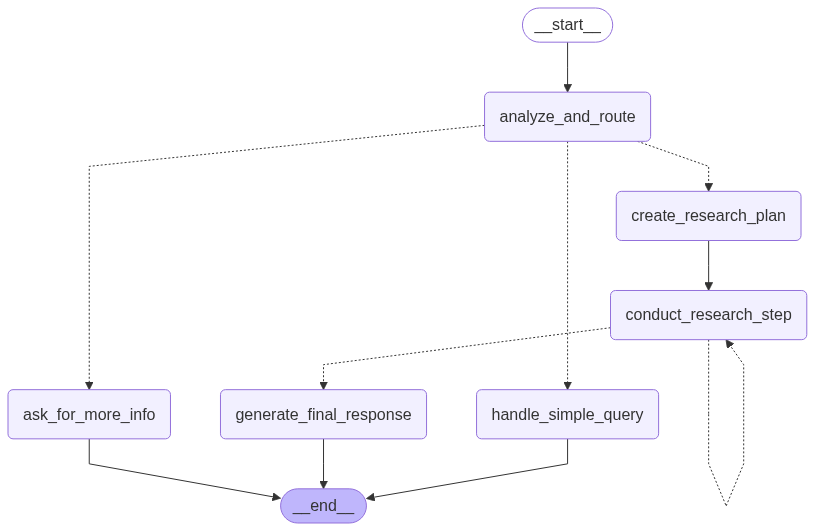

In [5]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
# 테스트 실행
async def test_workflow(question: str):
    input_state = InputState(messages=[HumanMessage(content=question)])
    thread = {"configurable": {"thread_id": "test-1"}}
    
    result = await app.ainvoke(input_state, config=thread)
    return result["final_answer"]

# 스트리밍 테스트 실행
async def test_workflow_streaming(question: str):
    input_state = InputState(messages=[HumanMessage(content=question)])
    thread = {"configurable": {"thread_id": "test-streaming"}}
    
    print(f"질문: {question}")
    print("\n--- 실행 과정 ---")
    
    async for chunk in app.astream(input_state, config=thread, stream_mode="updates"):
        for node_name, node_output in chunk.items():
            print(f"\n[{node_name}]")
            if "final_answer" in node_output:
                if hasattr(node_output["final_answer"], "content"):
                    print(node_output["final_answer"].content[:200] + "..." if len(node_output["final_answer"].content) > 200 else node_output["final_answer"].content)
                else:
                    print(str(node_output["final_answer"])[:200] + "..." if len(str(node_output["final_answer"])) > 200 else str(node_output["final_answer"]))
            elif "messages" in node_output:
                latest_message = node_output["messages"][-1] if node_output["messages"] else None
                if latest_message:
                    content = latest_message.content if hasattr(latest_message, 'content') else str(latest_message)
                    print(content[:200] + "..." if len(content) > 200 else content)
            elif "documents" in node_output and node_name == "conduct_research_step":
                # 참고 문서 정보 표시
                documents = node_output["documents"]
                print(f"참고 문서 {len(documents)}개:")
                for i, doc in enumerate(documents[:3]):  # 최대 3개 문서만 표시
                    file_name = doc.metadata.get('file_name', 'Unknown')
                    page_content = doc.page_content[:200] + "..." if len(doc.page_content) > 200 else doc.page_content
                    print(f"  문서 {i+1}: {file_name}")
                    print(f"  내용: {page_content}")
                    print()
                
                # 기존 출력도 유지
                print(f"출력: {str(node_output)[:200]}...")
            else:
                print(f"출력: {str(node_output)[:200]}...")
    
    # 최종 결과 반환
    final_state = app.get_state(thread)
    if "final_answer" in final_state.values:
        return final_state.values["final_answer"]
    return None

# 테스트 실행 방법:
# await test_workflow("스웨덴의 스타트업과 포드 기업의 차이점은 무엇인가요?")

In [7]:
await test_workflow_streaming("스웨덴의 스타트업과 포드 기업의 차이점은 무엇인가요?")

질문: 스웨덴의 스타트업과 포드 기업의 차이점은 무엇인가요?

--- 실행 과정 ---
질문 유형: complex - 질문은 '스웨덴의 스타트업과 포드 기업의 차이점'을 묻고 있어, 두 대상 간의 비교와 분석이 필요하므로 'complex'로 분류함.

[analyze_and_route]
출력: {'query_type': 'complex', 'routing_logic': "질문은 '스웨덴의 스타트업과 포드 기업의 차이점'을 묻고 있어, 두 대상 간의 비교와 분석이 필요하므로 'complex'로 분류함."}...
연구 계획 생성 중...
생성된 연구 계획: ["질의 정의 및 범위 설정: '스웨덴 스타트업'과 '포드 기업'의 정의(산업 분야, 설립 시기, 규모 등)를 구체적으로 규정하고, 비교 분석의 주요 축(조직 구조, 자금 조달, 혁신 방식 등)을 선정합니다.", '자료 수집 – 스웨덴 스타트업: Vinnova, Sveriges Startupportal 등 공식 기관 보고서와 Spotify·Klarna 등 대표 사례의 조직 문화, 투자 유치 구조, 제품 개발 프로세스를 조사합니다.', '자료 수집 – 포드 기업: 포드의 연례 보고서(Annual Report), SEC 보고서, 산업 분석 보고서 등을 통해 조직 규모, 지배구조, 재무 현황, 글로벌 생산·판매 전략을 파악합니다.', '비교 분석: 수집된 정보를 바탕으로 자금 조달 모델(벤처 캐피털 vs. 공개 시장), 의사결정 속도, 혁신 주도 방식, 위험 관리, 조직 문화 차이 등을 항목별로 정리·비교합니다.', '종합 정리 및 보고서 작성: 주요 차이점을 요약하여 도표나 매트릭스로 시각화하고, 결론 및 시사점을 포함한 최종 보고서를 작성합니다.']

[create_research_plan]
출력: {'research_steps': ["질의 정의 및 범위 설정: '스웨덴 스타트업'과 '포드 기업'의 정의(산업 분야, 설립 시기, 규모 등)를 구체적으로 규정하고, 비교 분석의 주요 축(조직 구조, 자금 조달, 혁신

'사용자 질문:  \n**스웨덴의 스타트업과 포드 기업의 차이점은 무엇인가요?**\n\n---\n\n## 1. 요약\n\n스웨덴의 스타트업과 포드(Ford) 기업은 산업 분야, 조직 규모, 자금 조달 방식, 혁신 주도 방식, 조직 문화 등 여러 측면에서 본질적으로 다릅니다. 스웨덴 스타트업은 주로 기술 및 혁신 중심의 신생 기업으로, 벤처 캐피털과 민간 투자에 의존하며 빠른 의사결정과 유연한 조직 문화를 특징으로 합니다. 반면, 포드는 100년 이상의 역사를 가진 대규모 자동차 제조 기업으로, 공개 시장 자금 조달과 전통적인 대기업 조직 구조를 갖추고 있으며, 대규모 생산과 글로벌 공급망 관리에 중점을 둡니다. 또한, 스웨덴 스타트업은 혁신 생태계 내에서 정부, 학계, 민간 부문과의 협력을 통해 성장하는 반면, 포드는 자체 R&D와 대규모 제조 역량을 기반으로 경제에 큰 영향을 미칩니다.\n\n---\n\n## 2. 주요 내용 (세부 분석)\n\n### 2.1 정의 및 산업 분야\n\n- **스웨덴 스타트업**  \n  - 주로 기술, 디지털 서비스, 바이오테크, 핀테크 등 혁신 산업에 집중  \n  - 대표 사례: Spotify(음악 스트리밍), Klarna(핀테크)  \n  - 설립 시기: 최근 10~20년 내외의 신생 기업들  \n  - 규모: 소규모에서 중간 규모, 빠른 성장 단계에 있음\n\n- **포드 기업**  \n  - 자동차 및 관련 부품 제조업체  \n  - 설립 시기: 1903년, 100년 이상의 역사와 전통 보유  \n  - 규모: 글로벌 대기업, 수십만 명의 직원과 광범위한 생산 및 판매 네트워크 보유\n\n### 2.2 조직 구조 및 문화\n\n- **스웨덴 스타트업**  \n  - 유연하고 수평적인 조직 구조  \n  - 빠른 의사결정과 혁신 촉진을 위한 민첩한 문화  \n  - 기업가 정신이 강하며, 실패를 학습의 기회로 보는 개방적 태도  \n  - 정부와 민간 부문, 학계가 협력하는 인큐베이터 및 스타트업 클러스터 내에서 성장\

In [8]:
from IPython.display import Markdown

display(Markdown('사용자 질문:  \n**스웨덴의 스타트업과 포드 기업의 차이점은 무엇인가요?**\n\n---\n\n## 1. 요약\n\n스웨덴의 스타트업과 포드(Ford) 기업은 산업 분야, 조직 규모, 자금 조달 방식, 혁신 주도 방식, 조직 문화 등 여러 측면에서 본질적으로 다릅니다. 스웨덴 스타트업은 주로 기술 및 혁신 중심의 신생 기업으로, 벤처 캐피털과 민간 투자에 의존하며 빠른 의사결정과 유연한 조직 문화를 특징으로 합니다. 반면, 포드는 100년 이상의 역사를 가진 대규모 자동차 제조 기업으로, 공개 시장 자금 조달과 전통적인 대기업 조직 구조를 갖추고 있으며, 대규모 생산과 글로벌 공급망 관리에 중점을 둡니다. 또한, 스웨덴 스타트업은 혁신 생태계 내에서 정부, 학계, 민간 부문과의 협력을 통해 성장하는 반면, 포드는 자체 R&D와 대규모 제조 역량을 기반으로 경제에 큰 영향을 미칩니다.\n\n---\n\n## 2. 주요 내용 (세부 분석)\n\n### 2.1 정의 및 산업 분야\n\n- **스웨덴 스타트업**  \n  - 주로 기술, 디지털 서비스, 바이오테크, 핀테크 등 혁신 산업에 집중  \n  - 대표 사례: Spotify(음악 스트리밍), Klarna(핀테크)  \n  - 설립 시기: 최근 10~20년 내외의 신생 기업들  \n  - 규모: 소규모에서 중간 규모, 빠른 성장 단계에 있음\n\n- **포드 기업**  \n  - 자동차 및 관련 부품 제조업체  \n  - 설립 시기: 1903년, 100년 이상의 역사와 전통 보유  \n  - 규모: 글로벌 대기업, 수십만 명의 직원과 광범위한 생산 및 판매 네트워크 보유\n\n### 2.2 조직 구조 및 문화\n\n- **스웨덴 스타트업**  \n  - 유연하고 수평적인 조직 구조  \n  - 빠른 의사결정과 혁신 촉진을 위한 민첩한 문화  \n  - 기업가 정신이 강하며, 실패를 학습의 기회로 보는 개방적 태도  \n  - 정부와 민간 부문, 학계가 협력하는 인큐베이터 및 스타트업 클러스터 내에서 성장\n\n- **포드 기업**  \n  - 전통적인 대기업형 조직 구조 (다단계 관리 계층)  \n  - 명확한 책임과 권한 분배, 체계적인 의사결정 프로세스  \n  - 안정성과 지속 가능성에 중점, 위험 관리가 엄격함  \n  - 대규모 제조 및 글로벌 공급망 관리에 최적화된 조직\n\n### 2.3 자금 조달 모델\n\n- **스웨덴 스타트업**  \n  - 주로 벤처 캐피털, 엔젤 투자, 민간 투자자 자금에 의존  \n  - 정부 지원 프로그램 및 인큐베이터를 통한 초기 자금 지원 존재  \n  - 외국인 직접 투자(FDI) 유치에 적극적이나, 스웨덴 대기업의 스타트업 투자 비율은 낮음(약 20%)  \n  - 민간 자본과 해외 투자 유치가 성장의 핵심 동력\n\n- **포드 기업**  \n  - 공개 시장(주식시장)에서 대규모 자본 조달  \n  - 자체 수익과 대규모 투자 자본을 활용한 R&D 및 생산 설비 투자  \n  - 안정적인 현금 흐름과 신용 등급을 기반으로 한 금융 전략 운영\n\n### 2.4 혁신 방식 및 성장 전략\n\n- **스웨덴 스타트업**  \n  - 혁신은 제품 및 서비스 개발의 핵심  \n  - 빠른 프로토타입 제작과 시장 테스트를 통한 민첩한 혁신 주도  \n  - 글로벌 시장 진출을 위한 네트워크 및 협력 강화  \n  - 정부 정책과 민간 부문의 협력을 통한 혁신 생태계 조성\n\n- **포드 기업**  \n  - 자체 R&D 센터와 대규모 연구 인프라를 통한 기술 혁신  \n  - 자동차 산업 내 지속 가능한 기술(전기차, 자율주행 등) 개발에 집중  \n  - 글로벌 생산 및 판매 네트워크를 통한 시장 확대  \n  - 혁신과 안정성의 균형을 맞추는 전략적 접근\n\n### 2.5 경제적 및 사회적 영향\n\n- **스웨덴 스타트업**  \n  - 국가 경제 내 신산업 창출과 고용 확대에 기여  \n  - 혁신 생태계 활성화를 통한 장기적 성장 동력 제공  \n  - 외국 기업에 의한 스타트업 인수가 많아, 글로벌 연결성 강화\n\n- **포드 기업**  \n  - 미국 GDP에 약 1,000억 달러 기여 (생산 및 승수 효과 포함)  \n  - 수백만 명의 고용 창출 및 지역사회 경제 활성화  \n  - 자동차 산업의 핵심 기업으로서 국가 산업 경쟁력 유지에 기여\n\n---\n\n## 3. 결론\n\n스웨덴의 스타트업과 포드 기업은 본질적으로 다른 유형의 조직으로, 각각의 산업적 맥락과 성장 단계, 조직 문화, 자금 조달 방식에서 큰 차이를 보입니다. 스웨덴 스타트업은 혁신과 민첩성을 바탕으로 빠르게 성장하는 신생 기업으로, 벤처 캐피털과 정부 지원을 통해 글로벌 시장 진출을 모색합니다. 반면, 포드는 전통적인 대기업으로서 대규모 자본과 조직력을 바탕으로 자동차 산업 내에서 안정적이고 지속 가능한 성장을 추구합니다. 스웨덴 스타트업은 혁신 생태계 내에서 유연성과 창의성을 중시하는 반면, 포드는 체계적이고 규모의 경제를 활용하는 경영 방식을 채택하고 있습니다. 따라서 두 조직 유형은 산업적 역할과 경제적 영향 면에서 상호 보완적이며, 각자의 강점을 살려 지속 가능한 성장을 도모하고 있습니다.\n\n---\n\n필요시, 스웨덴 스타트업의 혁신 생태계 강화 방안과 포드의 경제적 영향 분석에 관한 추가 정보도 제공 가능합니다.'
))

사용자 질문:  
**스웨덴의 스타트업과 포드 기업의 차이점은 무엇인가요?**

---

## 1. 요약

스웨덴의 스타트업과 포드(Ford) 기업은 산업 분야, 조직 규모, 자금 조달 방식, 혁신 주도 방식, 조직 문화 등 여러 측면에서 본질적으로 다릅니다. 스웨덴 스타트업은 주로 기술 및 혁신 중심의 신생 기업으로, 벤처 캐피털과 민간 투자에 의존하며 빠른 의사결정과 유연한 조직 문화를 특징으로 합니다. 반면, 포드는 100년 이상의 역사를 가진 대규모 자동차 제조 기업으로, 공개 시장 자금 조달과 전통적인 대기업 조직 구조를 갖추고 있으며, 대규모 생산과 글로벌 공급망 관리에 중점을 둡니다. 또한, 스웨덴 스타트업은 혁신 생태계 내에서 정부, 학계, 민간 부문과의 협력을 통해 성장하는 반면, 포드는 자체 R&D와 대규모 제조 역량을 기반으로 경제에 큰 영향을 미칩니다.

---

## 2. 주요 내용 (세부 분석)

### 2.1 정의 및 산업 분야

- **스웨덴 스타트업**  
  - 주로 기술, 디지털 서비스, 바이오테크, 핀테크 등 혁신 산업에 집중  
  - 대표 사례: Spotify(음악 스트리밍), Klarna(핀테크)  
  - 설립 시기: 최근 10~20년 내외의 신생 기업들  
  - 규모: 소규모에서 중간 규모, 빠른 성장 단계에 있음

- **포드 기업**  
  - 자동차 및 관련 부품 제조업체  
  - 설립 시기: 1903년, 100년 이상의 역사와 전통 보유  
  - 규모: 글로벌 대기업, 수십만 명의 직원과 광범위한 생산 및 판매 네트워크 보유

### 2.2 조직 구조 및 문화

- **스웨덴 스타트업**  
  - 유연하고 수평적인 조직 구조  
  - 빠른 의사결정과 혁신 촉진을 위한 민첩한 문화  
  - 기업가 정신이 강하며, 실패를 학습의 기회로 보는 개방적 태도  
  - 정부와 민간 부문, 학계가 협력하는 인큐베이터 및 스타트업 클러스터 내에서 성장

- **포드 기업**  
  - 전통적인 대기업형 조직 구조 (다단계 관리 계층)  
  - 명확한 책임과 권한 분배, 체계적인 의사결정 프로세스  
  - 안정성과 지속 가능성에 중점, 위험 관리가 엄격함  
  - 대규모 제조 및 글로벌 공급망 관리에 최적화된 조직

### 2.3 자금 조달 모델

- **스웨덴 스타트업**  
  - 주로 벤처 캐피털, 엔젤 투자, 민간 투자자 자금에 의존  
  - 정부 지원 프로그램 및 인큐베이터를 통한 초기 자금 지원 존재  
  - 외국인 직접 투자(FDI) 유치에 적극적이나, 스웨덴 대기업의 스타트업 투자 비율은 낮음(약 20%)  
  - 민간 자본과 해외 투자 유치가 성장의 핵심 동력

- **포드 기업**  
  - 공개 시장(주식시장)에서 대규모 자본 조달  
  - 자체 수익과 대규모 투자 자본을 활용한 R&D 및 생산 설비 투자  
  - 안정적인 현금 흐름과 신용 등급을 기반으로 한 금융 전략 운영

### 2.4 혁신 방식 및 성장 전략

- **스웨덴 스타트업**  
  - 혁신은 제품 및 서비스 개발의 핵심  
  - 빠른 프로토타입 제작과 시장 테스트를 통한 민첩한 혁신 주도  
  - 글로벌 시장 진출을 위한 네트워크 및 협력 강화  
  - 정부 정책과 민간 부문의 협력을 통한 혁신 생태계 조성

- **포드 기업**  
  - 자체 R&D 센터와 대규모 연구 인프라를 통한 기술 혁신  
  - 자동차 산업 내 지속 가능한 기술(전기차, 자율주행 등) 개발에 집중  
  - 글로벌 생산 및 판매 네트워크를 통한 시장 확대  
  - 혁신과 안정성의 균형을 맞추는 전략적 접근

### 2.5 경제적 및 사회적 영향

- **스웨덴 스타트업**  
  - 국가 경제 내 신산업 창출과 고용 확대에 기여  
  - 혁신 생태계 활성화를 통한 장기적 성장 동력 제공  
  - 외국 기업에 의한 스타트업 인수가 많아, 글로벌 연결성 강화

- **포드 기업**  
  - 미국 GDP에 약 1,000억 달러 기여 (생산 및 승수 효과 포함)  
  - 수백만 명의 고용 창출 및 지역사회 경제 활성화  
  - 자동차 산업의 핵심 기업으로서 국가 산업 경쟁력 유지에 기여

---

## 3. 결론

스웨덴의 스타트업과 포드 기업은 본질적으로 다른 유형의 조직으로, 각각의 산업적 맥락과 성장 단계, 조직 문화, 자금 조달 방식에서 큰 차이를 보입니다. 스웨덴 스타트업은 혁신과 민첩성을 바탕으로 빠르게 성장하는 신생 기업으로, 벤처 캐피털과 정부 지원을 통해 글로벌 시장 진출을 모색합니다. 반면, 포드는 전통적인 대기업으로서 대규모 자본과 조직력을 바탕으로 자동차 산업 내에서 안정적이고 지속 가능한 성장을 추구합니다. 스웨덴 스타트업은 혁신 생태계 내에서 유연성과 창의성을 중시하는 반면, 포드는 체계적이고 규모의 경제를 활용하는 경영 방식을 채택하고 있습니다. 따라서 두 조직 유형은 산업적 역할과 경제적 영향 면에서 상호 보완적이며, 각자의 강점을 살려 지속 가능한 성장을 도모하고 있습니다.

---

필요시, 스웨덴 스타트업의 혁신 생태계 강화 방안과 포드의 경제적 영향 분석에 관한 추가 정보도 제공 가능합니다.